## Import `tf` Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

## Define Model

$$
\begin{matrix}
X_1 \rightarrow N_1(X_1) & & \\
  & \searrow & \\
  &          & \oplus & \rightarrow & N_3 \bigg( \underbrace{N_1(E(X_1))}_\text{text}, \underbrace{N_2(X_2)}_\text{func rating} \bigg) \\
  & \nearrow & \\
X_2 \rightarrow N_2(X_2) & & \\
\end{matrix}
$$

There are two input channels for the neural network model:
- The input channel number 1 takes $X_1$ as input argument, and is fed into an embedding layer, $E(X_1)$. The output is then fitted using a neural network, $N_1(E(X_1))$.
- The input channel number 2 takes a single numerical input, $X_2$, and is fed into a shallow neural network, $N_2(X_2)$.
- The ouputs of both neural network is concatenated into a latent layer, $l = \oplus(N_1(E(X_1)), N_2(X)_2)$, which then is fed into another neural network, $N_3(l)$, for further learning.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

# Define function to create the neural network model
def create_nn_model(vocab_size: int, embedding_dim: int, max_length: int, num_of_dense: int, output_dim: int) -> Model:
    """
    Creates a neural network model that processes user prompts using an embedding layer,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        vocab_size (int): Size of the vocabulary for embedding.
        embedding_dim (int): Dimensionality of the embedding layer.
        max_length (int): Maximum length of input sequences.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input (user prompt)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
    flatten = Flatten()(embedding)

    # Dense layers for text input
    num_neurons = 2**12  # Start with 4096 neurons
    x = flatten
    for _ in range(num_of_dense):
        num_neurons = max(1, int(num_neurons / 2))  # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation='relu')(x)

    # Numeric input (func_rating)
    func_rating_input = Input(shape=(1,), name="func_rating_input")
    y = Dense(32, activation='relu')(func_rating_input)

    # Concatenate both paths
    concatenated = Concatenate()([x, y])
    # output = Dense(1, activation='linear', name="output")(concatenated)
    output = Dense(output_dim, activation='softmax', name="output")(concatenated)

    # Define and compile the model
    model = Model(inputs=[text_input, func_rating_input], outputs=output)

    # Set up learning rate scheduler
    # code here:

    # Compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Prep Data

In [ ]:
# Generate a larger sample dataset with 20 rows
data = {
    "user_prompt": [
        "I have just been on an international flight",
        "How can I improve my sleep quality?",
        "What are the symptoms of vitamin D deficiency?",
        "Best exercises for lower back pain relief",
        "Healthy meal ideas for weight loss",
        "How to reduce stress and anxiety naturally?",
        "What are the benefits of intermittent fasting?",
        "Tips for maintaining healthy skin",
        "How much water should I drink daily?",
        "Best ways to boost immune system",
        "Exercises to improve posture",
        "How to manage time effectively?",
        "Signs and symptoms of dehydration",
        "What foods help lower cholesterol?",
        "How to stay productive while working remotely?",
        "What are the dangers of processed foods?",
        "How to get better sleep without medication?",
        "Ways to increase energy levels naturally",
        "How does meditation help mental health?",
        "Best strategies to quit smoking"
    ],
    "func_rating": [3, 4, 2, 5, 3, 4, 5, 3, 4, 5, 3, 4, 2, 5, 3, 4, 5, 3, 4, 5],
    "custom_rating": [4, 5, 3, 4, 4, 5, 5, 4, 4, 5, 3, 5, 3, 4, 4, 3, 5, 4, 4, 5]
}

# Convert to DataFrame and display
df = pd.DataFrame(data)

When using `to_categorical` function, watch out for unique levels in `custom_rating` column.

In [ ]:
df["custom_rating"].unique()

array([4, 5, 3])

In [ ]:
df.shape

(20, 3)

In [ ]:
import pandas as pd
import requests
from io import StringIO

def download_and_combine_csv(urls: list) -> pd.DataFrame:
    """
    Download CSV files from provided URLs and combine them row-wise.
    It will combine files if they have the expected column names or just the correct number of columns.
    Handles different encodings to avoid common decoding errors. Converts certain columns to integer form.

    Args:
    urls (list): List of strings containing the URLs of the CSV files.

    Returns:
    pd.DataFrame: A DataFrame containing the combined data from all matching CSV files.
    """
    expected_columns = {'user_prompt', 'url_to_check', 'func_rating', 'custom_rating'}
    combined_df = pd.DataFrame()

    for url in urls:
        try:
            # Modify the GitHub URL to point to the raw version of the file
            raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob', '')

            response = requests.get(raw_url)
            if response.status_code == 200:
                try:
                    # Attempt to read with utf-8 encoding
                    content = response.content.decode('utf-8')
                except UnicodeDecodeError:
                    # Attempt to read with latin1 encoding
                    content = response.content.decode('latin1')

                # Read the CSV file into a DataFrame
                df = pd.read_csv(StringIO(content))

                # Check if the columns match the expected columns or if there are at least 4 columns
                if set(df.columns) == expected_columns:
                    combined_df = pd.concat([combined_df, df], ignore_index=True)
                elif len(df.columns) >= 4:
                    # Assume the first 4 columns are the required ones and ignore the original column names
                    df = df.iloc[:, :4]
                    df.columns = ['user_prompt', 'url_to_check', 'func_rating', 'custom_rating']
                    combined_df = pd.concat([combined_df, df], ignore_index=True)
                else:
                    print(f"Skipping file with insufficient columns: {url}")
            else:
                print(f"Failed to download from {url}")
        except Exception as e:
            print(f"Error processing {url}: {str(e)}")

    # Ensure func_rating and custom_rating are integers
    if not combined_df.empty:
        combined_df['func_rating'] = combined_df['func_rating'].round().astype(int)
        combined_df['custom_rating'] = combined_df['custom_rating'].round().astype(int)

    return combined_df


In [ ]:
# Example usage:
urls = [
    "https://github.com/vrutika-prajapati/Credibility-Score-for-Articles/blob/main/projects/deliverable%202/Url_validation.csv",
    "https://github.com/Saikumar08-sk/URL-Validation/blob/main/Deliverable.csv",
    "https://github.com/aditya19111/Project-1-Credibility-Score-for-Articles-Sources-References/blob/main/Deliverable_2/Deliverables_rating_comparison%20-%20Sheet1.csv",
    "https://github.com/SAIKUMAR500/algorithums-for-data-science/blob/main/deliverable2/dataset(Sheet1).csv",
    "https://github.com/drashti-sanghani/Credibility_score_articles/blob/main/Project/Deliverable2/user_ratings.csv",
    "https://github.com/anchalrai101/CREDIBILITY-SCORE/blob/main/urltesting_scores.csv",
    "https://github.com/AliSInamdar/CS676-Ali-Inamdar/blob/Project_1_Credibilty_Score/Deliverable_2/Deliverable_2.csv",
    "https://github.com/bhavnaa22/Algorithms-For-Data-Science/blob/main/Deliverable%202/Deliverable2.csv",
    "https://github.com/bhatthardik4/AlgorithmDS/blob/main/Deliverable_2/HardikBhattD2.csv",
    "https://github.com/Rakeshkanche/Algorithms-for-Data-Science/blob/main/queries_urls_ratings.csv",
    "https://github.com/kristinakim-code/Credibility-Check/blob/main/deliverable2.csv",
    "https://github.com/bhavnaa22/Algorithms-For-Data-Science/blob/main/Deliverable%202/Deliverable2.csv",
    "https://github.com/kamaldomandula/Algorithms-of-data-science-Project/blob/main/Project/project1/Deliverable2/deliverable.csv",
    "https://github.com/ChinmayShetye26/Algo-for-DS-delivery2/blob/main/Sample.csv",
    "https://github.com/krishnam229/Project1/blob/main/deliverable2/sample.csv",
    "https://github.com/drona23/Deliverable2/blob/main/output.csv",
]

In [ ]:
result_df = download_and_combine_csv(urls)
result_df.head()

,user_prompt,url_to_check,func_rating,custom_rating
0,"I have just been on an international flight, c...",https://www.mayoclinic.org/healthy-lifestyle/i...,2,3
1,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,4
2,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,2
3,What are the benefits of a vegetarian diet?,https://pubmed.ncbi.nlm.nih.gov/37226630/#:~:t...,2,3
4,How to improve mental health during stressful ...,https://www.who.int/news-room/questions-and-an...,3,3


In [ ]:
df = result_df.copy()

print(df.shape)

(282, 4)


### Tokenizer to Process Text

In [ ]:
# Tokenize and prepare data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["user_prompt"])
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(x.split()) for x in df["user_prompt"]])
embedding_dim = 8

# Convert text data into sequences
X_text = tokenizer.texts_to_sequences(df["user_prompt"])
X_text = pad_sequences(X_text, maxlen=max_length, padding='post')
print(X_text.shape)

# Numeric input
X_func_rating = np.array(df["func_rating"]).reshape(-1, 1)
print(X_func_rating.shape)

# Target variable
y = np.array(df["custom_rating"]).reshape(-1, 1)
print(y.shape)

(282, 26)
(282, 1)
(282, 1)


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and prepare data for BERT
def prepare_data(texts):
    """
    Prepares input text data into tokenized tensors for BERT.

    Args:
    texts (pd.Series): A pandas series containing text entries.

    Returns:
    tf.Tensor: Tokenized and formatted input for BERT.
    """
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512, # Can adjust depending on your specific needs
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

# Example usage
X_text, X_mask = prepare_data(df["user_prompt"])

print(X_text.shape)  # This will show the shape of your input_ids
print(X_mask.shape)  # This will show the shape of your attention masks


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

(282, 512)
(282, 512)


In [ ]:
X_mask

<tf.Tensor: shape=(282, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
df["custom_rating"].unique()

array([3, 4, 2, 5, 1, 0])

In [ ]:
from keras.utils import to_categorical

# Assuming y is your array of class labels shaped as (20, 1)
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y > 3)

# Check the new shape of y_one_hot
print(y_one_hot.shape)

(282, 2)


## Instantiate Model

In [ ]:
# Create the model
num_of_dense_layers = 2  # Example: 2 dense layers before concatenation
model = create_nn_model(vocab_size, embedding_dim, max_length, num_of_dense_layers, 2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Example of setting parameters based on your dataset
vocab_size = 30  # Example for BERT-base which has a vocab size of about 30,522
embedding_dim = 100  # Example dimensionality
max_length = 512  # From your output, each input sequence length
num_of_dense = 10  # Example of using three dense layers
output_dim = 2  # Number of output classes, change this as per your specific task

# Initialize the model with the parameters
model = create_nn_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, num_of_dense=num_of_dense, output_dim=output_dim)

## Training

In [ ]:
%%time

# Train the model
model.fit(
    {"text_input": X_text, "func_rating_input": X_func_rating},
    y_one_hot,
    epochs=2000,
    batch_size=5,
    validation_split=0.05,
    verbose=2
)

Epoch 1/2000
54/54 - 12s - 221ms/step - accuracy: 0.6966 - loss: 0.7156 - val_accuracy: 0.8000 - val_loss: 0.4732
Epoch 2/2000
54/54 - 1s - 26ms/step - accuracy: 0.6442 - loss: 0.6410 - val_accuracy: 0.8000 - val_loss: 0.6128
Epoch 3/2000
54/54 - 1s - 26ms/step - accuracy: 0.7566 - loss: 0.6267 - val_accuracy: 0.8000 - val_loss: 0.5505
Epoch 4/2000
54/54 - 1s - 26ms/step - accuracy: 0.7603 - loss: 0.6005 - val_accuracy: 0.8000 - val_loss: 0.5036
Epoch 5/2000
54/54 - 1s - 27ms/step - accuracy: 0.7603 - loss: 0.5620 - val_accuracy: 0.8000 - val_loss: 0.5119
Epoch 6/2000
54/54 - 1s - 27ms/step - accuracy: 0.7603 - loss: 0.5564 - val_accuracy: 0.8000 - val_loss: 0.5298
Epoch 7/2000
54/54 - 1s - 27ms/step - accuracy: 0.7603 - loss: 0.5558 - val_accuracy: 0.8000 - val_loss: 0.4891
Epoch 8/2000
54/54 - 1s - 27ms/step - accuracy: 0.7603 - loss: 0.5574 - val_accuracy: 0.8000 - val_loss: 0.4906
Epoch 9/2000
54/54 - 1s - 26ms/step - accuracy: 0.7603 - loss: 0.5496 - val_accuracy: 0.8000 - val_los

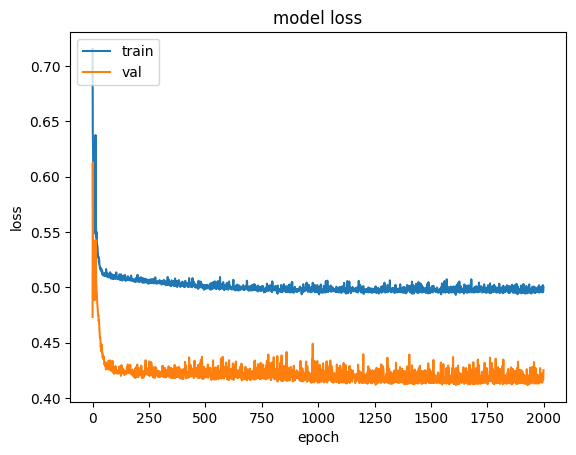

In [ ]:
# Plot error
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 512, 100)       │          3,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 51200)          │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2048)           │    104,859,648 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1024)           │      2,098,176 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 512)            │        524,800 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        131,328 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 32)             │          2,080 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 16)             │            528 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 8)              │            136 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 4)              │             36 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 36)             │              0 │ dense_12[0][0],        │
│ (Concatenate)             │                        │                │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 2)              │             74 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 322,983,068 (1.20 GB)

 Trainable params: 107,661,022 (410.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 215,322,046 (821.39 MB)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities for the test set
# Assume X_test_text and X_test_func_rating are your test datasets prepared similarly to your training datasets
predictions = model.predict({"text_input": X_text, "func_rating_input": X_func_rating})

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since y_test is in one-hot encoded format, convert it back to class labels for evaluation
true_classes = np.argmax(y_one_hot, axis=1)

# Generate a classification report
report = classification_report(true_classes, predicted_classes)
print(report)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       215
           1       0.50      0.19      0.28        67

    accuracy                           0.76       282
   macro avg       0.64      0.57      0.57       282
weighted avg       0.72      0.76      0.72       282



In [ ]:
67/(215+67)

0.2375886524822695

## Create Repo on HF

In [ ]:
! pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [ ]:
from huggingface_hub import HfApi

hf_username = "eagle0504"  # Replace with your Hugging Face username
repo_name = "my-tf-nn-model-v7"  # Change this as needed
repo_id = f"{hf_username}/{repo_name}"

api = HfApi()

# Create the repository
api.create_repo(repo_id=repo_id, exist_ok=True)  # exist_ok=True prevents errors if the repo already exists

print(f"Repository created: https://huggingface.co/{repo_id}")

Repository created: https://huggingface.co/eagle0504/my-tf-nn-model-v7


## Push Artifacts on HF

In [ ]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"eagle0504/{repo_name}"  # Change as needed
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

tokenizer.pkl:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/eagle0504/my-tf-nn-model-v7


## Download Model Artifact from HF

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Set Keras backend to JAX (Optional, only needed if you want to experiment with JAX backend)
os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
# repo_id = "eagle0504/my-tf-nn-model" # we already defined it above
filename = "model.keras"  # Ensure this matches what was uploaded

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the Keras model
new_model = keras.models.load_model(model_path)

print("Model loaded successfully!")

model.keras:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 8, 16)          │          1,376 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │        264,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      2,098,176 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 544)            │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │          3,270 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,675,636 (33.09 MB)

 Trainable params: 2,891,878 (11.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,783,758 (22.06 MB)

## Local Inference

In [ ]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define repo details
# repo_id = "eagle0504/my-tf-nn-model" # we already defined above

# Download model
# model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
# new_model = keras.models.load_model(model_path)

# Download tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.pkl")

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")

# Sample test data
test_texts = [
    "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
]

# Preprocess test data using the loaded tokenizer
max_length = model.input_shape[0][1]  # Get max_length from model input shape
X_text_test = tokenizer.texts_to_sequences(test_texts)
X_text_test = pad_sequences(X_text_test, maxlen=max_length, padding='post')

# Dummy numeric input (func_rating)
X_func_test = np.array([5, 4]).reshape(-1, 1)

# Make predictions
predictions = new_model.predict({"text_input": X_text_test, "func_rating_input": X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Rating: {predictions[i][0]:.2f}")
    print("-" * 50)

tokenizer.pkl:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Prompt: How to improve focus and concentration?
Predicted Rating: 0.00
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 0.00
--------------------------------------------------
